In [1]:
# Import necessary libraries for numerical computations, plotting, and utility functions
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional
from typing import Literal
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set up the device to use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a random seed for reproducibility across runs
seed = 42
random.seed(seed)  # Seed for Python's random module
np.random.seed(seed)  # Seed for NumPy
torch.manual_seed(seed)  # Seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # Seed for PyTorch (GPU)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

Using device: cpu


In [2]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces


class TicTacToeEnv(gym.Env):
    """0 for empty; 1 for Player 1; 2 for Player 2"""

    def __init__(self) -> None:
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(0, 2, shape=(3, 3), dtype=np.int64)
        self._board = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
        self.next_player = 1

    @classmethod
    def check_winner(cls, board: np.ndarray) -> int:
        """Return winning player index or 0 if no winner"""
        # Check rows for a win
        for row in board:
            if row[0] == row[1] == row[2] and row[0] != 0:
                return row[0]

        # Check columns for a win
        for col in range(3):
            if board[0][col] == board[1][col] == board[2][col] and board[0][col] != 0:
                return board[0][col]

        # Check diagonals for a win
        if board[0][0] == board[1][1] == board[2][2] and board[0][0] != 0:
            return board[0][0]
        if board[0][2] == board[1][1] == board[2][0] and board[0][2] != 0:
            return board[0][2]

        return 0

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed)
        self._board = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
        self.next_player = 1
        return self._board, {"last_player": 0}

    def step(self, action: int):
        """
        Reward:
            - invalid move: -10
            - winning: 5
            - normal: 0
            - board full: 0
        """
        cur_player = self.next_player
        self.next_player = cur_player % 2 + 1
        if self._board[action // 3][action % 3] != 0:
            return self._board, -10, False, False, {"last_player": cur_player}
        
        self._board[action // 3][action % 3] = cur_player
        has_won = self.check_winner(self._board) == cur_player
        board_full = np.count_nonzero(self._board) == 9
        return self._board, 5 if has_won else 0, has_won or board_full, False, {"last_player": cur_player}

    def render(self):
        int_to_symbol = {0: " ", 1: "X", 2: "O"}
        for row in self._board:
            for num in row:
                print(int_to_symbol[num], end="", flush=True)
            print("", flush=True)

In [3]:
# Define the Q-Network architecture
class DQN(nn.Module):
    """Simple MLP Q-Network"""

    def __init__(self, n_observations: int, n_actions: int, dueling=True, random=False):
        """
        Initialize the DQN.

        Parameters:
        - n_observations (int): Dimension of the state space.
        - n_actions (int): Number of possible actions.
        """
        super(DQN, self).__init__()

        self.backbone = nn.Sequential(
            nn.Embedding(3, 16),
            nn.Flatten(),
            nn.PReLU(),
            nn.Linear(16 * 9, 128),
            nn.PReLU(),
            nn.Linear(128, 128),
            nn.PReLU(),
        )

        # Dueling DQN, where Q-values = V + A - mean(A)
        self.out_A = nn.Linear(
            128, n_actions
        )  # Output layer (A-values for each action)
        if dueling:
            self.out_V = nn.Linear(128, 1)  # Output layer (V-value)
        self.dueling = dueling
        self.random = random

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        if self.random:
            return torch.where(
                x == 0, torch.rand_like(x, dtype=torch.float), torch.zeros_like(x)
            ).to(torch.float)

        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.int, device=device)
        elif x.dtype != torch.int:
            x = x.to(dtype=torch.int)

        # Apply layers with ReLU activation
        x = self.backbone(x)
        A: torch.Tensor = self.out_A(x)
        if not self.dueling:
            return A
        V = self.out_V(x)
        return V + A - A.mean(dim=1, keepdim=True)

In [4]:
net1 = DQN(9, 9)
net2 = DQN(9, 9, random=True)

input_data = torch.randint(0, 3, [128, 9])
print(net1(input_data).shape)
print(net2(input_data).shape)

torch.Size([128, 9])
torch.Size([128, 9])


In [5]:
# Define the structure for storing transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Define the Replay Memory class
class ReplayMemory(object):
    """ Stores transitions and allows sampling batches. """
    def __init__(self, capacity: int):
        """
        Initialize the Replay Memory.

        Parameters:
        - capacity (int): Maximum number of transitions to store.
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """
        Save a transition.

        Parameters:
        - *args: The transition elements (state, action, next_state, reward, done).
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int) -> List[Transition]:
        """
        Sample a random batch of transitions from memory.

        Parameters:
        - batch_size (int): The number of transitions to sample.

        Returns:
        - List[Transition]: A list containing the sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """ Return the current size of the memory. """
        return len(self.memory)

In [6]:
# Action Selection (Epsilon-Greedy - Modified for single state tensor input)
def select_action_custom(state: torch.Tensor,
                         policy_net: nn.Module,
                         epsilon_start: float,
                         epsilon_end: float,
                         epsilon_decay: int,
                         n_actions: int) -> Tuple[torch.Tensor, float]:
    """
    Selects an action using the epsilon-greedy strategy for a single state tensor.

    Parameters:
    - state (torch.Tensor): The current state as a tensor of shape [state_dim].
    - policy_net (nn.Module): The Q-network used to estimate Q-values.
    - epsilon_start (float): Initial value of epsilon (exploration rate).
    - epsilon_end (float): Final value of epsilon after decay.
    - epsilon_decay (int): Decay rate for epsilon (higher value means slower decay).
    - n_actions (int): Number of possible actions.

    Returns:
    - Tuple[torch.Tensor, float]: 
        - The selected action as a tensor of shape [1, 1].
        - The current epsilon value after decay.
    """
    global steps_done_custom  # Counter to track the number of steps taken
    sample = random.random()  # Generate a random number for epsilon-greedy decision
    # Compute the current epsilon value based on the decay formula
    epsilon_threshold = epsilon_end + (epsilon_start - epsilon_end) * \
        math.exp(-1. * steps_done_custom / epsilon_decay)
    steps_done_custom += 1  # Increment the step counter

    if sample > epsilon_threshold:
        # Exploitation: Choose the action with the highest Q-value
        with torch.no_grad():
            # Add a batch dimension to the state tensor to make it [1, state_dim]
            state_batch = state.unsqueeze(0)
            # Get the action with the maximum Q-value (output shape: [1, n_actions])
            action = policy_net(state_batch).max(1)[1].view(1, 1)  # Reshape to [1, 1]
    else:
        # Exploration: Choose a random action
        action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

    return action, epsilon_threshold

In [7]:
def optimize_model(memory: ReplayMemory,
                   policy_net: nn.Module,
                   target_net: nn.Module,
                   optimizer: optim.Optimizer,
                   batch_size: int,
                   gamma: float,
                   criterion: nn.Module = nn.SmoothL1Loss(), 
                   method:Literal["dqn", "ddqn"]="ddqn") -> Optional[float]:
    """
    Performs one step of optimization on the policy network.

    Parameters:
    - memory (ReplayMemory): The replay memory containing past transitions.
    - policy_net (nn.Module): The main Q-network being optimized.
    - target_net (nn.Module): The target Q-network used for stable target computation.
    - optimizer (optim.Optimizer): The optimizer for updating the policy network.
    - batch_size (int): The number of transitions to sample for each optimization step.
    - gamma (float): The discount factor for future rewards.
    - criterion (nn.Module): The loss function to use (default: SmoothL1Loss).

    Returns:
    - Optional[float]: The loss value for the optimization step, or None if not enough samples.
    """
    # Ensure there are enough samples in memory to perform optimization
    if len(memory) < batch_size:
        return None

    # Sample a batch of transitions from replay memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))  # Unpack transitions into separate components

    # Identify non-final states (states that are not terminal)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)

    # Stack non-final next states into a tensor
    if any(non_final_mask):  # Check if there are any non-final states
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    # Stack current states, actions, rewards, and dones into tensors
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    done_batch = torch.cat(batch.done)

    # Compute Q(s_t, a) for the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for the next states using the target network
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        if any(non_final_mask):  # Only compute for non-final states
            if method == "dqn":
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
            elif method == "ddqn":
                max_actions = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
                next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, max_actions).squeeze(1)


    # Compute the expected Q values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute the loss between predicted and expected Q values
    loss: torch.Tensor = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    if loss.requires_grad:
        # Perform backpropagation and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)  # Clip gradients to prevent explosion
        optimizer.step()  # Update the policy network

    return loss.item()  # Return the loss value for logging

In [8]:
def update_target_net(policy_net: nn.Module, target_net: nn.Module) -> None:
    """
    Copies the weights from the policy network to the target network.

    Parameters:
    - policy_net (nn.Module): The main Q-network whose weights are to be copied.
    - target_net (nn.Module): The target Q-network to which weights are copied.

    Returns:
    - None
    """
    target_net.load_state_dict(policy_net.state_dict())

In [9]:
# Hyperparameters for Custom Grid World
BATCH_SIZE_CUSTOM = 128
GAMMA_CUSTOM = 0.99         # Discount factor (encourage looking ahead)
EPS_START_CUSTOM = 1.0      # Start with full exploration
EPS_END_CUSTOM = 0.1       # End with 5% exploration
EPS_DECAY_CUSTOM = 10000    # Slower decay for potentially larger state space exploration needs
TAU_CUSTOM = 0.005          # Tau for soft updates (alternative, not used here)
LR_CUSTOM = 3e-4            # Learning rate (might need tuning)
MEMORY_CAPACITY_CUSTOM = 10000
TARGET_UPDATE_FREQ_CUSTOM = 50 # Update target net less frequently maybe
NUM_EPISODES_CUSTOM = 20000      # More episodes might be needed
MAX_STEPS_PER_EPISODE_CUSTOM = 30 # Max steps per episode (grid size related)

In [10]:
# Re-instantiate the custom GridEnvironment
custom_env = TicTacToeEnv()

# Get the size of the action space and state dimension
n_actions_custom: int = spaces.flatdim(custom_env.action_space)  # Number of possible actions (3, 3)
n_observations_custom: int = spaces.flatdim(custom_env.observation_space)  # Dimension of the state space (9)
print(n_actions_custom, n_observations_custom)

# Initialize the policy network (main Q-network) and target network
policy_nets_custom: list[DQN] = [DQN(n_observations_custom, n_actions_custom, random=True).to(device),
                                DQN(n_observations_custom, n_actions_custom, dueling=True).to(device)]  # Main Q-network
target_nets_custom: list[DQN] = [DQN(n_observations_custom, n_actions_custom, random=True).to(device),
                                DQN(n_observations_custom, n_actions_custom, dueling=True).to(device)]  # Main Q-network

# Copy the weights from the policy network to the target network and set it to evaluation mode
target_nets_custom[0].load_state_dict(policy_nets_custom[0].state_dict())  # Synchronize weights
target_nets_custom[0].eval()  # Set target network to evaluation mode
target_nets_custom[1].load_state_dict(policy_nets_custom[1].state_dict())  # Synchronize weights
target_nets_custom[1].eval()  # Set target network to evaluation mode

# Initialize the optimizer for the policy network
optimizers_custom: list[optim.AdamW] = [optim.AdamW(policy_nets_custom[0].parameters(), lr=LR_CUSTOM, amsgrad=True),
                                        optim.AdamW(policy_nets_custom[1].parameters(), lr=LR_CUSTOM, amsgrad=True)]

# Initialize the replay memory with the specified capacity
memories_custom: list[ReplayMemory] = [ReplayMemory(MEMORY_CAPACITY_CUSTOM), ReplayMemory(MEMORY_CAPACITY_CUSTOM)]

# Lists for plotting
episode_rewards_1_custom = []
episode_lengths_1_custom = []
episode_epsilons_1_custom = []
episode_losses_1_custom = []

9 9


In [11]:
print("Starting DQN Training on Custom Grid World...")

# Initialize the global counter for epsilon decay
steps_done_custom = 0

# Training Loop
for i_episode in range(NUM_EPISODES_CUSTOM):
    # Reset the environment and get the initial state tensor
    state, info = custom_env.reset()
    state_tensor = torch.tensor(spaces.flatten(custom_env.observation_space, state), device=device)
    total_reward = 0
    current_losses = []

    last_states : list[torch.Tensor|None] = [None, None]
    last_rewards : list[int|None] = [None, None]

    for t in range(MAX_STEPS_PER_EPISODE_CUSTOM):
        player_idx = custom_env.next_player - 1
        other_idx = 1 - player_idx

        # Select an action using epsilon-greedy policy
        action_tensor, current_epsilon = select_action_custom(
            state_tensor, policy_nets_custom[player_idx], EPS_START_CUSTOM, EPS_END_CUSTOM, EPS_DECAY_CUSTOM, n_actions_custom
        )
        action = int(action_tensor.item())

        # Take a step in the environment
        next_state, reward, term, trun, info = custom_env.step(action)
        assert info["last_player"] == player_idx + 1
        done = term or trun
        next_state_tensor = torch.tensor(spaces.flatten(custom_env.observation_space, next_state), device=device)

        last_rewards[player_idx] = reward
        last_player_state = last_states[player_idx]
        last_states[player_idx] = next_state_tensor
        if any([e is None for lst in [last_rewards, last_states] for e in lst] + [last_player_state is None]):
            continue
        
        player_reward = -last_rewards[other_idx] + reward

        # Prepare tensors for storing in replay memory
        reward_tensor = torch.tensor([player_reward], device=device, dtype=torch.float32)
        action_tensor_mem = torch.tensor([[action]], device=device, dtype=torch.long)
        done_tensor = torch.tensor([done], device=device, dtype=torch.bool)

        # Store the transition in replay memory
        memory_next_state = next_state_tensor if not done else None
        assert last_player_state is not None
        assert last_player_state is not memory_next_state
        memories_custom[player_idx].push(last_player_state, action_tensor_mem, memory_next_state, reward_tensor, done_tensor)

        # Move to the next state
        state_tensor = next_state_tensor

        # Perform one optimization step on the policy network
        loss = optimize_model(
            memories_custom[player_idx], policy_nets_custom[player_idx], target_nets_custom[player_idx], optimizers_custom[player_idx], BATCH_SIZE_CUSTOM, GAMMA_CUSTOM, method="ddqn"
        )

        if player_idx == 1:
            total_reward += reward
            if loss is not None:
                current_losses.append(loss)

        # Break the loop if the episode is done
        if done:
            break

    # Store episode statistics
    episode_rewards_1_custom.append(total_reward)
    episode_lengths_1_custom.append(t + 1)
    episode_epsilons_1_custom.append(current_epsilon)
    episode_losses_1_custom.append(np.mean(current_losses) if current_losses else 0)

    # Update the target network periodically
    if i_episode % TARGET_UPDATE_FREQ_CUSTOM == 0:
        update_target_net(policy_nets_custom[0], target_nets_custom[0])
        update_target_net(policy_nets_custom[1], target_nets_custom[1])

    # Print progress every 50 episodes
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards_1_custom[-50:])
        avg_length = np.mean(episode_lengths_1_custom[-50:])
        avg_loss = np.mean([l for l in episode_losses_1_custom[-50:] if l > 0])
        print(
            f"Episode {i_episode+1}/{NUM_EPISODES_CUSTOM} | "
            f"Avg Reward (last 50): {avg_reward:.2f} | "
            f"Avg Length: {avg_length:.2f} | "
            f"Avg Loss: {avg_loss:.4f} | "
            f"Epsilon: {current_epsilon:.3f}"
        )

print("Custom Grid World Training Finished.")

Starting DQN Training on Custom Grid World...


C:\Users\cyrus.kfcheung\AppData\Local\Temp\ipykernel_49660\1299968735.py:44: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  done_tensor = torch.tensor([done], device=device, dtype=torch.bool)


Episode 50/20000 | Avg Reward (last 50): -31.90 | Avg Length: 14.50 | Avg Loss: 3.0548 | Epsilon: 0.937
Episode 100/20000 | Avg Reward (last 50): -26.40 | Avg Length: 13.38 | Avg Loss: 2.9336 | Epsilon: 0.883
Episode 150/20000 | Avg Reward (last 50): -21.20 | Avg Length: 11.72 | Avg Loss: 3.1875 | Epsilon: 0.838
Episode 200/20000 | Avg Reward (last 50): -15.80 | Avg Length: 10.72 | Avg Loss: 3.4650 | Epsilon: 0.800
Episode 250/20000 | Avg Reward (last 50): -21.80 | Avg Length: 11.90 | Avg Loss: 3.6627 | Epsilon: 0.759
Episode 300/20000 | Avg Reward (last 50): -16.00 | Avg Length: 10.88 | Avg Loss: 3.7828 | Epsilon: 0.725
Episode 350/20000 | Avg Reward (last 50): -16.50 | Avg Length: 10.90 | Avg Loss: 3.7113 | Epsilon: 0.691
Episode 400/20000 | Avg Reward (last 50): -14.50 | Avg Length: 10.50 | Avg Loss: 3.7819 | Epsilon: 0.661
Episode 450/20000 | Avg Reward (last 50): -12.20 | Avg Length: 10.40 | Avg Loss: 3.5868 | Epsilon: 0.633
Episode 500/20000 | Avg Reward (last 50): -19.80 | Avg L

KeyboardInterrupt: 

In [ ]:
memories_custom[0].memory[10]

Transition(state=tensor([1, 0, 0, 0, 0, 1, 0, 2, 0]), action=tensor([[5]]), next_state=tensor([1, 0, 0, 0, 0, 1, 0, 2, 0]), reward=tensor([-10.]), done=tensor([False]))

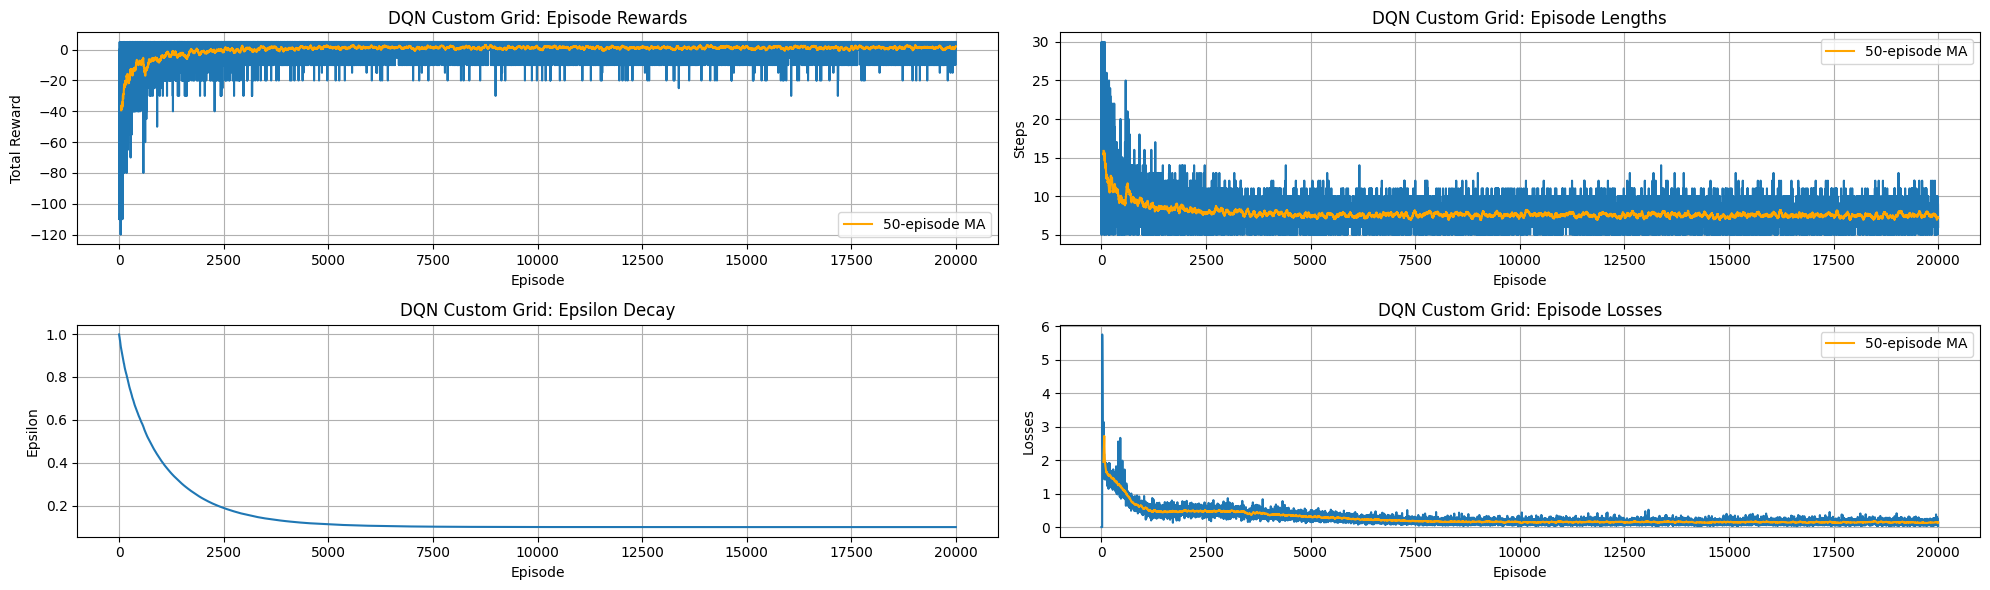

In [ ]:
# Plotting results for Custom Grid World
plt.figure(figsize=(20, 6))

# Rewards
plt.subplot(2, 2, 1)
plt.plot(episode_rewards_1_custom)
plt.title('DQN Custom Grid: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
rewards_ma_custom = np.convolve(episode_rewards_1_custom, np.ones(50)/50, mode='valid')
if len(rewards_ma_custom) > 0: # Avoid plotting empty MA
    plt.plot(np.arange(len(rewards_ma_custom)) + 49, rewards_ma_custom, label='50-episode MA', color='orange')
plt.legend()


# Lengths
plt.subplot(2, 2, 2)
plt.plot(episode_lengths_1_custom)
plt.title('DQN Custom Grid: Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
lengths_ma_custom = np.convolve(episode_lengths_1_custom, np.ones(50)/50, mode='valid')
if len(lengths_ma_custom) > 0:
    plt.plot(np.arange(len(lengths_ma_custom)) + 49, lengths_ma_custom, label='50-episode MA', color='orange')
plt.legend()

# Epsilon
plt.subplot(2, 2, 3)
plt.plot(episode_epsilons_1_custom)
plt.title('DQN Custom Grid: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(episode_losses_1_custom)
plt.title('DQN Custom Grid: Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Losses')
plt.grid(True)
losses_ma_custom = np.convolve(episode_losses_1_custom, np.ones(50)/50, mode='valid')
if len(losses_ma_custom) > 0:
    plt.plot(np.arange(len(losses_ma_custom)) + 49, losses_ma_custom, label='50-episode MA', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import time

from IPython.display import clear_output


def print_env(env: TicTacToeEnv):
    env.render()
    


test_env = TicTacToeEnv()

print("Action:", None)
print_env(test_env)
time.sleep(0.7)

done = False

state, info = test_env.reset(seed=3)
state_tensor = torch.tensor(
    spaces.flatten(test_env.observation_space, state), device=device
)
while not done:
    idx = test_env.next_player - 1
    action_tensor, current_epsilon = select_action_custom(
        state_tensor, policy_nets_custom[idx], 1, 0.1, 1, n_actions_custom
    )
    action = int(action_tensor.item())
    next_state, reward, term, trun, info = test_env.step(action)
    done = term or trun
    state_tensor = torch.tensor(
        spaces.flatten(test_env.observation_space, next_state), device=device
    )
    clear_output(wait=True)
    print("Action:", action, next_state)
    print_env(test_env)
    time.sleep(0.7)

Action: 2 [[1 0 2]
 [0 0 0]
 [0 0 0]]
X O
   
   


KeyboardInterrupt: 